In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import lime.lime_tabular
import matplotlib.pyplot as plt
from sympy.integrals.manualintegrate import rewrites_rule

# Load the CSV file
data = pd.read_csv('/Users/zubairfaruqui/Downloads/optimization_log.csv')

# Process "Solution" column by stripping brackets and converting to floats
X = data["Solution"].apply(lambda x: np.array([float(i.strip("[]")) for i in x.split(',')]))
X = np.stack(X.values)  # Stack arrays into a 2D array

# Clean and convert "Fitness" column to a numpy array of floats
y_reg = data["Fitness"].apply(lambda x: float(x.strip("[]").strip())).values


# Convert "Satisfied Constraint" to binary values (1 for 'Yes', 0 otherwise)
y_class = data["Satisfied Constraints"].apply(lambda x: 1 if x == 9 else 0).values

# Split data into training and testing sets
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
_, _, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)

In [88]:
# Filter rows where Column B equals 1
filtered_df = data[data['Satisfied Constraints'] == 9]

# Find the row with the minimum value in Column A
min_row = filtered_df.loc[filtered_df['Fitness'].idxmin()]


# Get the index of the row with the minimum value in Column A
min_row_index = min_row.name

# Get the corresponding 'Solution' value for the min row index
min_row_solution_value = data.loc[min_row_index, 'Solution']

# Transform the solution value as you did for X
best_sol__X = np.array([float(i.strip("[]")) for i in min_row_solution_value.split(',')])


In [108]:
num_features = X_train.shape[1]

# Calculate correlations
correlations = np.array([np.corrcoef(X_train[:, i], y_train_reg)[0, 1] for i in range(num_features)])

# Print or analyze correlations
print(correlations)

[ 0.18173164  0.3782948   0.27103528  0.41030696  0.21010463  0.32463227
  0.17027373  0.21776071 -0.06945051 -0.84994126 -0.82650124 -0.85407115
  0.39289867]


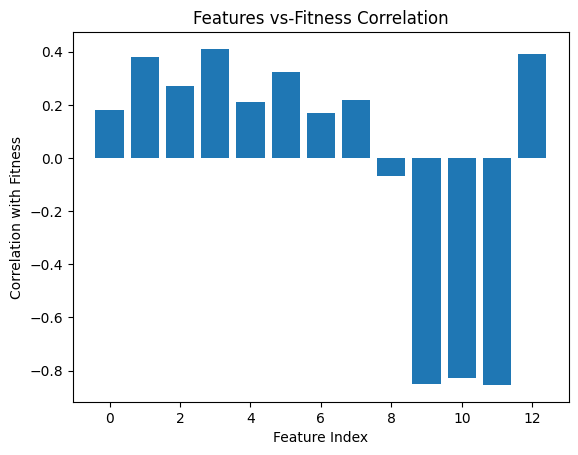

In [109]:
import matplotlib.pyplot as plt

# Plot the correlation values
plt.bar(range(num_features), correlations)
plt.xlabel('Feature Index')
plt.ylabel('Correlation with Fitness')
plt.title('Features vs-Fitness Correlation')
plt.show()


In [75]:

# Initialize models
regressor = RandomForestRegressor(n_estimators=100, random_state=42) # LinearRegression() 
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train models
regressor.fit(X_train, y_train_reg)
classifier.fit(X_train, y_train_class)

# Test models
y_pred_reg = regressor.predict(X_test)
y_pred_class = classifier.predict(X_test)

# Evaluate models
mse = mean_squared_error(y_test_reg, y_pred_reg)
accuracy = accuracy_score(y_test_class, y_pred_class)

print(f"Regression MSE: {mse}")
print(f"Classification Accuracy: {accuracy}")


Regression MSE: 3.2258485079381143
Classification Accuracy: 0.9995


In [ ]:
# Initialize the LIME explainer
limeRegressionExplainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    mode="regression",  # We'll use this mode for both models separately
    feature_names=[f'Feature_{i}' for i in range(X.shape[1])],
    random_state=42
)

limeClassifierExplainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    mode="classification",  # We'll use this mode for both models separately
    feature_names=[f'Feature_{i}' for i in range(X.shape[1])],
    class_names=np.unique(y_pred_class),
    random_state=42
)

# Function to get feature importance for both models
def get_feature_importance_lime(explainer, model, X_sample):
    if explainer.mode == 'regression':
        exp = explainer.explain_instance(X_sample, model.predict, num_features=X.shape[1])

    elif explainer.mode == 'classification':
        exp = explainer.explain_instance(X_sample, model.predict_proba, num_features=X.shape[1])
    # print(exp.as_list())
    return dict(exp.as_list())

In [93]:

# Test with a sample and store importance scores
#sample = X_test[0]
best_sol_score_reg = get_feature_importance_lime(limeRegressionExplainer, regressor, best_sol__X)
best_sol_score_class = get_feature_importance_lime(limeClassifierExplainer, classifier, best_sol__X)


In [78]:
def sortAsLimeExpAsNumpyAr(limeExpDict):    
    # Create a NumPy array where each row is a feature score
    fixedLimeDict = fixFeatureNameinLimeExpDictionary(limeExpDict)
    sortedLimeDictByKeys = sortDictByKeys(fixedLimeDict)
    importance_array = np.array(list(sortedLimeDictByKeys.values())).reshape(1, -1)

    # Optionally, map feature names to columns
    feature_names_array = np.array([list(sortedLimeDictByKeys.keys())]).reshape(1, -1)
    
    # Optionally, you can return both feature names and scores as a 2D array
    result_array = np.vstack((feature_names_array, importance_array))
    return result_array

In [79]:
reg_lime_score = None
class_lime_score = None
for x in X_test :
    # for regression
    reg_scores = get_feature_importance_lime(limeRegressionExplainer, regressor, x)
    sortedByKey_reg_scores = sortAsLimeExpAsNumpyAr (reg_scores)
    if( reg_lime_score is None):
        reg_lime_score = sortedByKey_reg_scores
    else:
        reg_lime_score = np.vstack((reg_lime_score, sortedByKey_reg_scores[1]))
    
    # for classify
    clas_scores = get_feature_importance_lime(limeClassifierExplainer, classifier, x)
    sortedByKey_clas_scores = sortAsLimeExpAsNumpyAr (clas_scores)
    if( class_lime_score is None):
        class_lime_score = sortedByKey_clas_scores
    else:
        class_lime_score = np.vstack((class_lime_score, sortedByKey_clas_scores[1]))

# print(reg_lime_score)
# print(class_lime_score)

In [80]:
def fixFeatureNameinLimeExpDictionary(limeExpDict):
    limeDictWithFixedFeatureNames = {extractFeatureNameFromLimeScoreRange(key): value for key, value in limeExpDict.items()}
    return limeDictWithFixedFeatureNames

In [81]:
def sortDictByKeys(limeExpDict):
    sorted_dict = {k: limeExpDict[k] for k in sorted(limeExpDict, key=lambda x: int(x.split('_')[1]))}
    return sorted_dict

In [82]:
import re
def extractFeatureNameFromLimeScoreRange(featureNameWithScoreRange):
    # Input string
    input_string = featureNameWithScoreRange
    feature_name = "dummy"
    # Find the start index of 'Feature_'
    start_index = input_string.find("Feature_")

# If 'Feature_' is found, extract the feature name
    if start_index != -1:
        feature_name = input_string[start_index:start_index + input_string[start_index:].find(' ')]
    return feature_name
# extractFeatureNameFromLimeScoreRange('2.26 < Feature_11 <= 2.91')

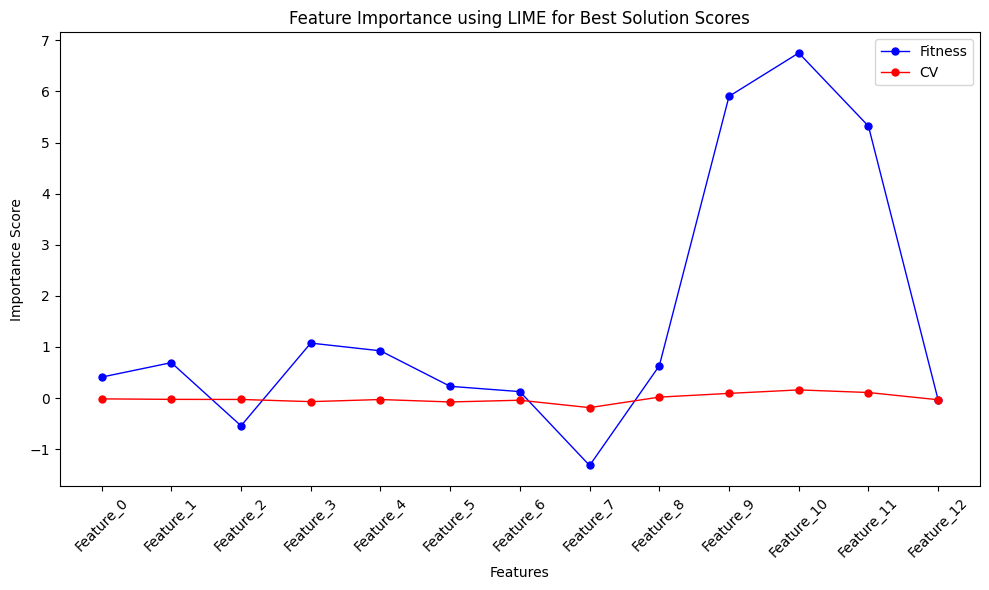

In [105]:
# Plotting function
def plot_feature_score_for_best_sol(score_reg, score_class, title):
    score_reg = sortAsLimeExpAsNumpyAr(score_reg)
    score_class = sortAsLimeExpAsNumpyAr(score_class)

    features = list(score_reg[0])
    reg_score_values = score_reg[1].astype(float)  # Exclude first row and convert to float
    
    plt.figure(figsize=(10, 6))
    plt.plot(features, reg_score_values, marker='o', color='blue', linestyle='-', linewidth=1, markersize=5, label='Fitness')
    
    class_score_values = score_class[1].astype(float)  # Exclude first row and convert to float
    plt.plot(features, class_score_values, marker='o', color='red', linestyle='-', linewidth=1, markersize=5, label='CV')


    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.title(f"Feature Importance using LIME for {title}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

# Plot feature importance for regression
plot_feature_score_for_best_sol(best_sol_score_reg, best_sol_score_class, "Best Solution Scores")

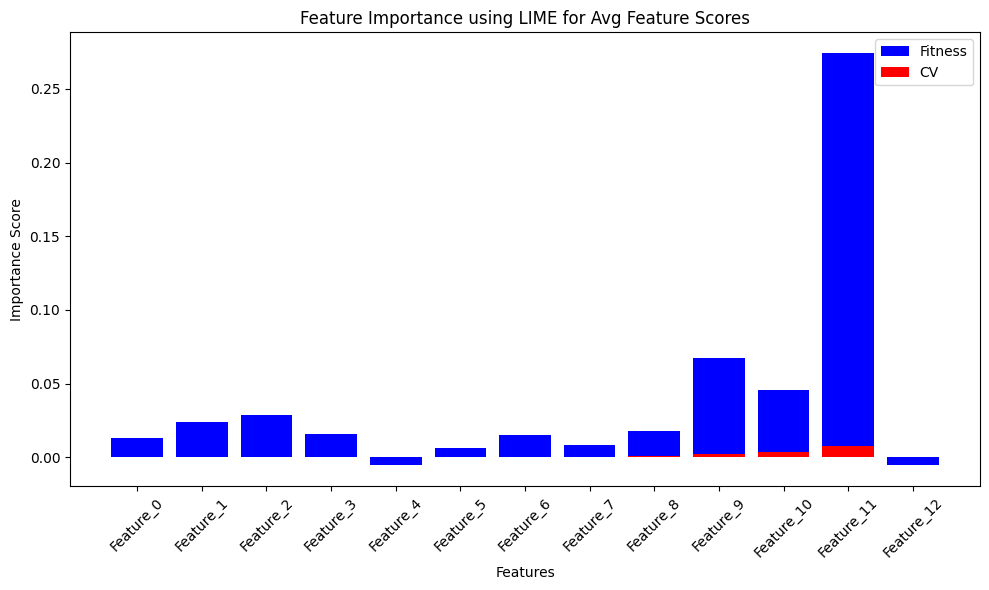

In [110]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reg_class_score(reg_score_matrix, class_score_matrix, title, isBarChart=True):
    plt.figure(figsize=(10, 6))

    features = list(reg_score_matrix[0])

    reg_data_values = reg_score_matrix[1:].astype(float)  # Exclude first row and convert to float

    reg_score_averages = np.mean(reg_data_values, axis=0)
    
    if(isBarChart is False):
        plt.plot(features, reg_score_averages, marker='o', color='blue', linestyle='-', linewidth=1, markersize=5, label='Fitness')
    else:
        plt.bar(features, reg_score_averages, color='blue', label='Fitness')

    class_data_values = class_score_matrix[1:].astype(float)  # Exclude first row and convert to float
    class_score_averages = np.mean(class_data_values, axis=0)
    if(isBarChart is False):
        plt.plot(features, class_score_averages, marker='x', color='red', linestyle='-', linewidth=1, markersize=5, label='CV')
    else:
        plt.bar(features, class_score_averages, color='red', label='CV')

    
    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.title(f"Feature Importance using LIME for {title}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot feature importance
plot_reg_class_score(reg_lime_score, class_lime_score, "Avg Feature Scores", True)


In [ ]:
import shap
# Initialize SHAP Explainer
explainer = shap.Explainer(regressor, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Optionally, explain a single instance
# sample_index = 0  # Index of the sample to explain
# shap_value_single = explainer(X_test[sample_index:sample_index+1])
# # Plot SHAP values for the chosen sample (individual explanation)
# shap.plots.waterfall(shap_value_single[0])

(-88.51901740582593, 10.067941506058043, -1.0, 13.0)


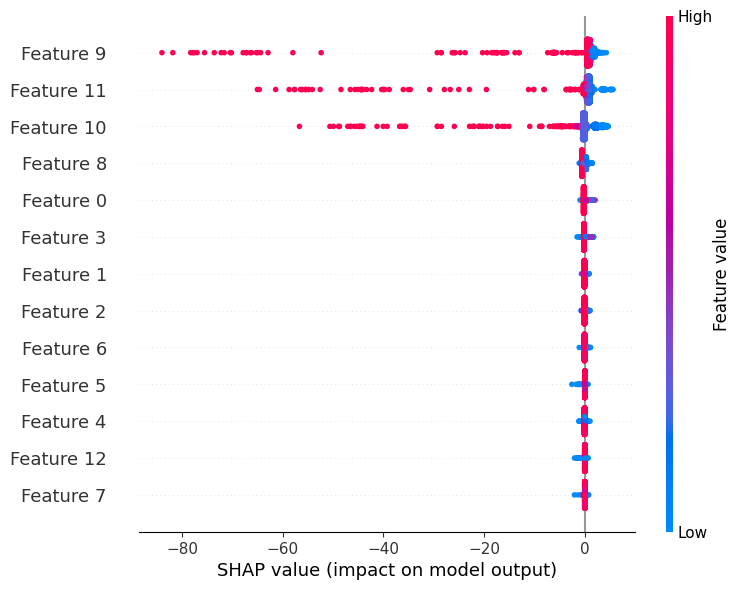

In [125]:

# Plot SHAP values summary for all test set (global explanation)
shap.plots.beeswarm(shap_values, max_display = 13, show = False)
print(plt.axis())

plt.show()

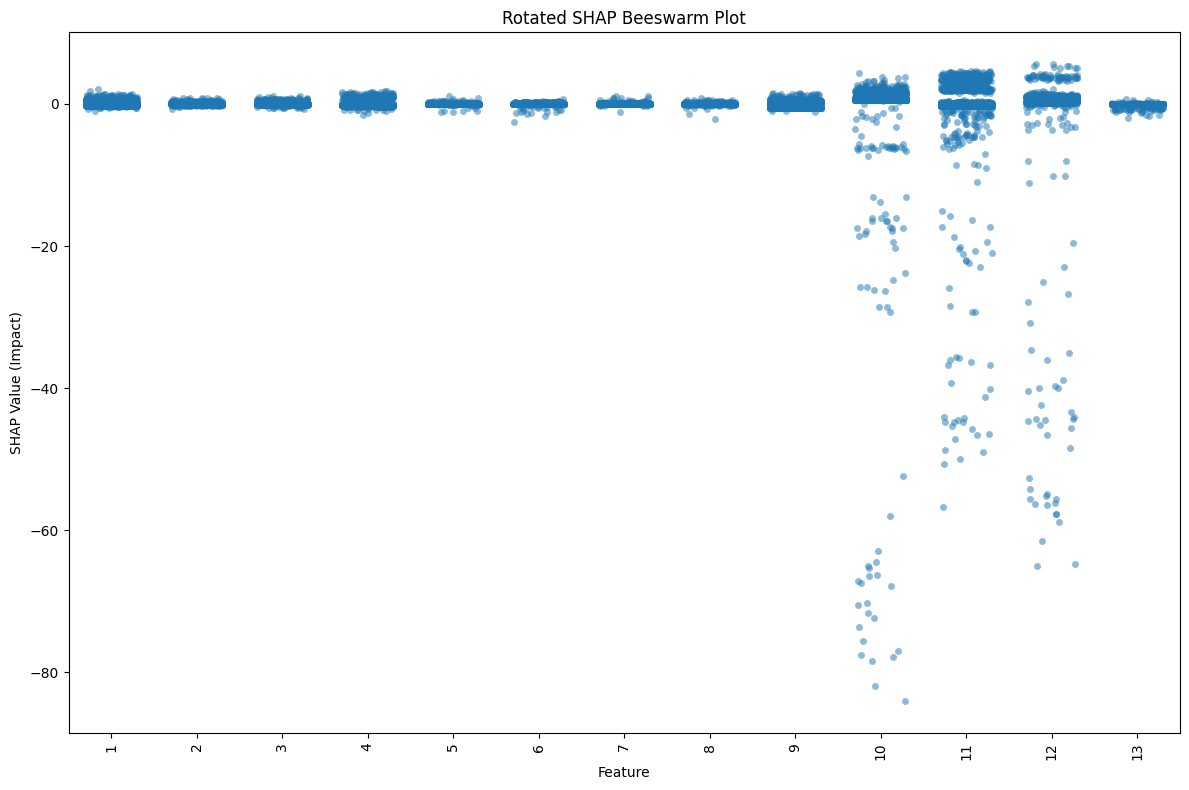

In [118]:
import seaborn as sns
# Convert SHAP values to a DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=(1,2,3,4,5,6,7,8,9,10,11,12,13))

# Melt the DataFrame to prepare for a seaborn plot
shap_melted = shap_df.melt(var_name="Feature", value_name="SHAP Value")

# Create a new plot with flipped axes
plt.figure(figsize=(12, 8))
sns.stripplot(data=shap_melted, x="Feature", y="SHAP Value", jitter=0.3, alpha=0.5)
plt.xlabel("Feature")
plt.ylabel("SHAP Value (Impact)")
plt.xticks(rotation=90)
plt.title("Rotated SHAP Beeswarm Plot")
plt.tight_layout()
plt.show()